## Evaluating Coar attributions 

We evaluate pre-computed attributions of an ImageNet ViT-B/16 model in this notebook.
Specifically, we quantifes the extent to which Coar attributions can accurately predict the counterfactual effect of ablating random $\alpha$-sized component subsets on model outputs.

In [1]:
import sys 
sys.path.append('..')

In [7]:
import functools 
import torch
import torchvision
from torch import nn
import seaborn as sns
import numpy as np

from src.models import cifar_resnet
from src.utils import ndm_utils, data_utils
from src.data import ffcv_pipelines
from evaluate import EvaluateCoar, get_masked_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download model, beton, and attributions 

In [3]:
# size ~ 13 GB 
# attributions
!wget 'https://www.dropbox.com/scl/fi/lm4hnvz4la8g9cg7ex9gp/imagenet_vit.pt?rlkey=6jz2rrrug1rw0zfdddeetooxo&dl=0' -O out/imagenet_attributions.pt
# dataloader in ffcv .beton format
!wget 'https://www.dropbox.com/scl/fi/ovztah82lk6qav1bkhpn3/imagenet_val.beton?rlkey=eroq5kcusbwdfecxk0xscnu3n&dl=0' -O out/imagenet_val.beton

--2024-02-13 03:34:04--  https://www.dropbox.com/scl/fi/lm4hnvz4la8g9cg7ex9gp/imagenet_vit.pt?rlkey=6jz2rrrug1rw0zfdddeetooxo&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc824adc7edb44b0391df79e5897.dl.dropboxusercontent.com/cd/0/inline/CNOAiPLED8mLVecpmaeZT9t8l86n298E9AHOpHs_L7NH4FloqfkZ1-FeCkZGv7mvOuv1TXcWdy5CfqDHV6ZXs_-Ou8wZW244BBB9Ox0C19N_k3-zohNZQP1hUQGdna0KyhmCIuyYOfq8Tm08r0KDpdkS/file# [following]
--2024-02-13 03:34:05--  https://uc824adc7edb44b0391df79e5897.dl.dropboxusercontent.com/cd/0/inline/CNOAiPLED8mLVecpmaeZT9t8l86n298E9AHOpHs_L7NH4FloqfkZ1-FeCkZGv7mvOuv1TXcWdy5CfqDHV6ZXs_-Ou8wZW244BBB9Ox0C19N_k3-zohNZQP1hUQGdna0KyhmCIuyYOfq8Tm08r0KDpdkS/file
Resolving uc824adc7edb44b0391df79e5897.dl.dropboxusercontent.com (uc824adc7edb44b0391df79e5897.dl.dropboxusercontent.com)... 162.125.4.15

### Evaluate 

In [5]:
DEVICE = torch.device(0) 

def get_model():
    weights = torchvision.models.vision_transformer.ViT_B_16_Weights.IMAGENET1K_V1
    model = torchvision.models.vit_b_16(weights=weights).eval()
    return model

def get_attributions():
    A = torch.load('out/imagenet_attributions.pt')
    A = A['weight'].T.float()
    return A

def get_loader(batch_size=128, num_workers=2):
    pipeline  = ffcv_pipelines.get_pipelines('imagenet', 'val', 'cuda')
    indices = np.arange(0, 50_000, 10)
    loader = data_utils.get_ffcv_loader('out/imagenet_val.beton', batch_size, num_workers, pipeline, is_train=False, indices=indices)
    return loader

def get_model_components(model):
    mod_comps = {}

    for comp_name, comp in model.named_modules():
        if comp_name.startswith('heads'):
            continue
        if isinstance(comp, nn.Linear):
            mod_comps[f'{comp_name}.weight'] = comp.weight.shape[0]
        elif isinstance(comp, nn.MultiheadAttention):
            mod_comps[f'{comp_name}.in_proj_weight'] = comp.in_proj_weight.shape[0]

    return mod_comps

In [8]:
model = get_model()
comps = get_model_components(model)
mask_model_wrapper = functools.partial(get_masked_model, comp_dims=comps)

attb = get_attributions()
loader = get_loader() 

coar_eval = EvaluateCoar(attb, get_model, mask_model_wrapper, loader, attb.shape[1], DEVICE)

In [9]:
mask_probs = [0.1, 0.05, 0.025]
num_runs = 100 
cor_df = coar_eval.get_correlation_dataframe(mask_probs, num_runs, use_tqdm=True)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.55s/it]


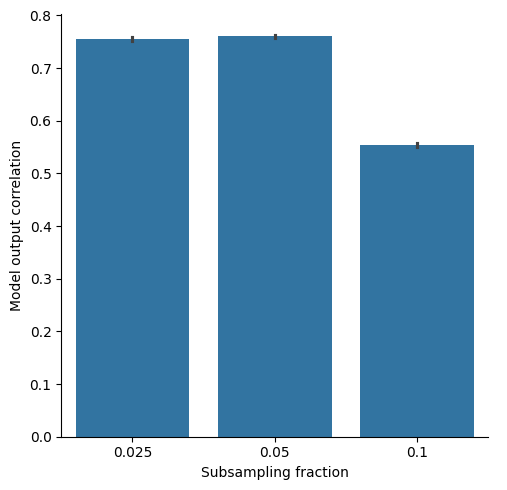

In [10]:
sns.catplot(data=cor_df, x='Subsampling fraction', y='Model output correlation', kind='bar')